In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 9.0 MB/s 


In [2]:
import mtcnn
print(mtcnn.__version__)

Using TensorFlow backend.


0.1.0


In [3]:
import numpy as np
import pandas as pd
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

import os
print(os.listdir("../input"))

['facerecog', 'facenet-keras']


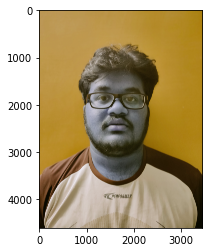

(4608, 3456, 3)


In [4]:
img = cv2.imread('../input/facerecog/Train/Rahul/IMG20200326211641.jpg')
plt.imshow(img)
plt.show()
print(img.shape)

In [5]:
type(img)

numpy.ndarray

In [6]:
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

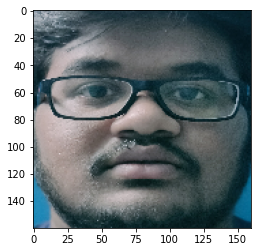

(160, 160, 3)


In [7]:
pixels = extract_face('../input/facerecog/Train/Rahul/IMG20200326211641.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [8]:
def load_face(dir):
    faces = list()
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) )
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [9]:
trainX, trainy = load_dataset('../input/facerecog/Train/')
print(trainX.shape, trainy.shape)
testX, testy = load_dataset('../input/facerecog/Val/')
print(testX.shape, testy.shape)

np.savez_compressed('Faces-dataset.npz', trainX, trainy, testX, testy)

loaded 19 sample for class: Nikitha
loaded 20 sample for class: Rahul
(39, 160, 160, 3) (39,)
loaded 5 sample for class: Nikitha
loaded 5 sample for class: Rahul
(10, 160, 160, 3) (10,)


In [10]:
data = np.load('Faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [11]:
facenet_model = load_model('../input/facenet-keras/facenet_keras.h5')

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
def get_embedding(model, face):
    face = face.astype('float32')
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    sample = np.expand_dims(face, axis=0)
    yhat = model.predict(sample)
    return yhat[0]
    
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

np.savez_compressed('Faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(39, 128)
(10, 128)


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC


in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX, trainy)

yhat_train = model.predict(emdTrainX)
yhat_test = model.predict(emdTestX)

score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


Predicted: 
[0, 1] 
[ 5.54893708 94.45106292]
Expected: Rahul


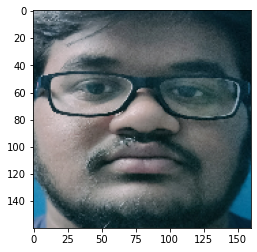

In [14]:
from random import choice
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX[selection]
random_face_class = testy[selection]
random_face_name = [random_face_class]

samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0]* 100
predict_names = yhat_class
all_names = [0,1]

print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])

plt.imshow(random_face)
plt.show()

In [15]:
import pickle

In [16]:
filename = 'Face_model.sav'
pickle.dump(model, open(filename, 'wb'))